In [6]:
import tensorflow as tf
import glob
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print(tf.__version__)
np.random.seed(1)

2.5.0
CPU times: user 102 µs, sys: 19 µs, total: 121 µs
Wall time: 110 µs


Load images from folders

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8)

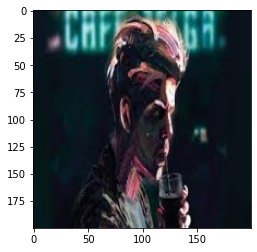

In [7]:
train_images = []
train_labels  = []
for file in glob.glob('covers/**/*.png', recursive=True):
    img_arr = np.asarray(PIL.Image.open(file).resize((200,200)))
    label = (file.split('/')[1] + "-" +  file.split('/')[2])
    if len(img_arr.shape) == 3:
        train_images.append(img_arr)
        train_labels.append(label)

train_labels = pd.get_dummies(train_labels).values
train_images = np.array(train_images)


x_train,x_test,y_train,y_test = train_test_split(train_images,train_labels,random_state=1)
plt.imshow(x_train[0])
y_train[0]


Prepare model

In [9]:
x,y,c = x_train[0].shape
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(kernel_size=(6,6), filters=64, input_shape=(x,y,c,), activation='tanh'))
model.add(tf.keras.layers.MaxPool2D(4,4))
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),activation='tanh'))
model.add(tf.keras.layers.MaxPool2D(2,2))
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),activation='tanh'))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(120,activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.01))
model.add(tf.keras.layers.Dense(60,activation='relu'))
model.add(tf.keras.layers.Dense(40,activation='relu'))
model.add(tf.keras.layers.Dense(units=len(train_labels[0]), activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='adam')

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 195, 195, 64)      6976      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 14112)             0         
_________________________________________________________________
dense (Dense)             

2021-11-18 23:02:57.147704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-18 23:02:57.147866: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model train

In [10]:
history = model.fit(x_train,y_train,epochs=10,batch_size=30,validation_data=(x_test,y_test))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.3 µs
Epoch 1/10


2021-11-18 23:03:01.897480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-18 23:03:01.897641: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-18 23:03:02.036246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 253ms/step - loss: 3.0092 - acc: 0.1533 - val_loss: 2.6516 - val_acc: 0.2000
Epoch 2/10


2021-11-18 23:03:03.231240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 231ms/step - loss: 2.3846 - acc: 0.2600 - val_loss: 2.6288 - val_acc: 0.2400
Epoch 3/10
5/5 [==============================] - 1s 232ms/step - loss: 1.9930 - acc: 0.3667 - val_loss: 2.3746 - val_acc: 0.1800
Epoch 4/10
5/5 [==============================] - 1s 231ms/step - loss: 1.7527 - acc: 0.3933 - val_loss: 2.2295 - val_acc: 0.3200
Epoch 5/10
5/5 [==============================] - 1s 232ms/step - loss: 1.7195 - acc: 0.4600 - val_loss: 1.7856 - val_acc: 0.3800
Epoch 6/10
5/5 [==============================] - 1s 235ms/step - loss: 1.3128 - acc: 0.6200 - val_loss: 1.6961 - val_acc: 0.4600
Epoch 7/10
5/5 [==============================] - 1s 231ms/step - loss: 1.1285 - acc: 0.6533 - val_loss: 1.5402 - val_acc: 0.5400
Epoch 8/10
5/5 [==============================] - 1s 240ms/step - loss: 0.9272 - acc: 0.6800 - val_loss: 1.6474 - val_acc: 0.5200
Epoch 9/10
5/5 [==============================] - 1s 235ms/step - loss: 0.6956 - acc: 0.8067 - val_lo

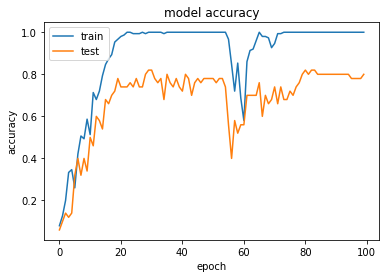

In [17]:


# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


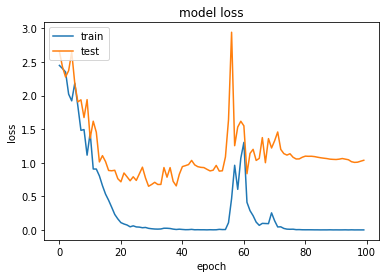

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()